# Compares dgms & an attempt at persistence images for dgms

- Input: ripser dgms (persistence diagram output as np arrays) files stored as pickles


IZI: infinite-zero index: (log(number infinite topological features + alpha) \ log(number zero topological features + alpha))
<br>     - infinite topological features = never die (extremely persistent features)
<br>     - zero topological features = die when they are born (noise)

Persistence Images: vectorize persistence diagrams 
<br>    - typically used for input in machine learning 

Author: @emilyekstrum
<br> 11/17/25

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import pickle as pkl
import os
from collections import defaultdict
import re
import seaborn as sns
import persim
from persim import PersistenceImager

In [3]:
# utils

def fraction_long_lived(dgm, epsilon=None, epsilon_frac=0.01, include_essential=False, cap_inf=None):
    """ Fraction of features whose lifetimes exceed epsilon.

    Args:
        dgm: (n,2) array-like persistence diagram
        epsilon: float or None, absolute lifetime threshold; if None, computed as epsilon_frac * span
        epsilon_frac: float, fraction of span to use as epsilon if epsilon is None
        include_essential: bool, whether to include essential features (with infinite death time)
        cap_inf: float or None, if include_essential is True, cap infinite deaths at this value; if None, use max finite death time
    Returns:
        float fraction of features with lifetime > epsilon """
    
    dgm = np.asarray(dgm, dtype=float)
    if dgm.size == 0:
        return 0.0

    births = dgm[:, 0]
    deaths = dgm[:, 1]
    is_inf = np.isinf(deaths)

    if include_essential:
        if cap_inf is None:
            finite_deaths = deaths[~is_inf]
            if finite_deaths.size == 0:
                cap = np.max(births)
            else:
                cap = np.max(finite_deaths)
        else:
            cap = float(cap_inf)
        deaths = np.where(is_inf, cap, deaths)
    else:
        keep = ~is_inf
        births, deaths = births[keep], deaths[keep]

    if births.size == 0:
        return 0.0

    lifetimes = deaths - births
    lifetimes = lifetimes[lifetimes > 0]
    if lifetimes.size == 0:
        return 0.0

    if epsilon is None:
        span = (np.max(deaths) - np.min(births))
        if span <= 0:
            return 0.0
        epsilon = float(epsilon_frac) * span

    return float(np.mean(lifetimes > epsilon))


def aggregate_fraction_by_dimension(dgms_by_cat, hom_deg_label="Hk", epsilon=None, epsilon_frac=0.01, include_essential=False, cap_inf=None,
                                    dims=(3,8,32), reducer="mean"):
    """Aggregate per-diagram fraction_long_lived results into long and aggregate dataframes
    
    Args:
        dgms_by_cat: dict category -> dim -> list of (n,2) arrays
        hom_deg_label: str label for homological degree
        epsilon: float or None, absolute lifetime threshold; if None, computed as epsilon_frac * span
        epsilon_frac: float, fraction of span to use as epsilon if epsilon is None
        include_essential: bool, whether to include essential features (with infinite death time)
        cap_inf: float or None, if include_essential is True, cap infinite deaths at this value; if None, use max finite death time
        dims: iterable of int dimensions to include
        reducer: str, "mean" or "median" for aggregation method 
    Returns:
        df_long: DataFrame with columns ["category","dim","sample_idx","frac_long","hom_deg"]
        df_agg: DataFrame with columns ["category","dim","frac_long","n_samples","sem"]"""
    
    rows = []
    dims_set = set(dims)

    for category, dim_map in dgms_by_cat.items():
        # dim_map should be a dict: dim -> list of diagrams
        for dim, diagrams in dim_map.items():
            if dim not in dims_set:
                continue
            for i, dgm in enumerate(diagrams):
                frac = fraction_long_lived(dgm, epsilon=epsilon, epsilon_frac=epsilon_frac,
                                           include_essential=include_essential, cap_inf=cap_inf)
                rows.append({
                    "category": category,
                    "dim": int(dim),
                    "sample_idx": i,
                    "frac_long": float(frac),
                    "hom_deg": hom_deg_label
                })

    df_long = pd.DataFrame(rows)

    # or use empy df structure
    if df_long.empty:
        df_agg = pd.DataFrame(columns=["category", "dim", "frac_long", "n_samples", "sem"])
        return df_long, df_agg

    agg_func = np.mean if reducer == "mean" else np.median
    def _sem(x):
        n = len(x)
        if n <= 1:
            return 0.0
        return float(np.std(x, ddof=1) / np.sqrt(n))

    df_agg = df_long.groupby(["category", "dim"], as_index=False).agg(
        frac_long=("frac_long", agg_func),
        n_samples=("frac_long", "size"),
        sem=("frac_long", _sem)
    )

    return df_long, df_agg


def plot_dim_pair_scatter(df_agg, title = "Fraction Lived"):
    """ Plot scatter plots comparing fraction_long_lived between pairs of dimensions.
    
    Args:
        df_agg: DataFrame with columns ['category','dim','frac_long','sem']
        title: str title for plots"""
    
    if df_agg is None or df_agg.empty:
        print("No aggregated data to plot.")
        return

    dims = sorted(df_agg['dim'].unique())
    for dim1, dim2 in combinations(dims, 2):
        dim1_df = df_agg[df_agg['dim'] == dim1].set_index('category')
        dim2_df = df_agg[df_agg['dim'] == dim2].set_index('category')
        if dim1_df.empty or dim2_df.empty:
            continue

        dim1_df = dim1_df.rename(columns={"frac_long": f"frac_long_{dim1}", "sem": f"sem_{dim1}"})
        dim2_df = dim2_df.rename(columns={"frac_long": f"frac_long_{dim2}", "sem": f"sem_{dim2}"})

        both = dim1_df[[f"frac_long_{dim1}", f"sem_{dim1}"]].join(dim2_df[[f"frac_long_{dim2}", f"sem_{dim2}"]], how="inner")
        if both.empty:
            continue

        x = both[f"frac_long_{dim1}"].values
        y = both[f"frac_long_{dim2}"].values
        ex = both[f"sem_{dim1}"].values
        ey = both[f"sem_{dim2}"].values

        plt.figure(figsize=(6,6))
        plt.errorbar(x, y, xerr=ex, yerr=ey, fmt='o', ecolor='gray', alpha=0.7)

        low = float(min(np.min(x), np.min(y), 0.0))
        high = float(max(np.max(x), np.max(y), 1.0))

        plt.plot([low, high], [low, high], 'k--', alpha=0.5)

        plt.xlabel(f"Fraction long-lived (dim={dim1})")
        plt.ylabel(f"Fraction long-lived (dim={dim2})")
        plt.title(title + f" (dim {dim1} vs dim {dim2})")
        plt.tight_layout()
        plt.show()

def plot_fraction_vs_epsilon(dgms_by_cat, dims=(3,8,24,32), n_eps=40, max_frac=0.2,
                             include_essential=False, cap_inf=None, reducer='mean',
                             figsize=(8,5), cmap='tab10'):
    """
    Plot mean fraction_long_lived vs epsilon for each requested dimension on a single plot.

    - dgms_by_cat: dict category -> dim -> list of (n,2) arrays
    - dims: dimensions of embeddings
    - n_eps: number of epsilon points between 0 and max_frac * span
    - max_frac: maximum fraction of the per-dimension filtration span to use as epsilon
    - return: DataFrame with columns ['dim','epsilon','mean_frac','sem','n']
    """
    rows = []
    dims = tuple(dims)

    # per-dim combined diagram lists
    dim_diagrams = {}
    for dim in dims:
        combined = []
        for cat, dim_map in dgms_by_cat.items():
            if dim in dim_map:
                combined.extend(dim_map[dim])
        # remove None or empty entries
        combined = [np.asarray(d, dtype=float) for d in combined if d is not None and d.size > 0]
        if len(combined) == 0:
            dim_diagrams[dim] = []
            continue
        dim_diagrams[dim] = combined

    # per-dim spans
    dim_spans = {}
    for dim, diagrams in dim_diagrams.items():
        if len(diagrams) == 0:
            dim_spans[dim] = 0.0
            continue
        min_birth = np.inf
        max_death = -np.inf
        for d in diagrams:
            if d.size == 0:
                continue
            births = d[:,0]
            deaths = d[:,1]
            # ignore inf for span calculation
            finite_deaths = deaths[np.isfinite(deaths)]
            if births.size > 0:
                min_birth = min(min_birth, np.min(births))
            if finite_deaths.size > 0:
                max_death = max(max_death, np.max(finite_deaths))
        if not np.isfinite(min_birth) or not np.isfinite(max_death) or max_death - min_birth <= 0:
            dim_spans[dim] = 0.0
        else:
            dim_spans[dim] = float(max_death - min_birth)

    # to plot use fraction of span between 0 and max_frac
    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.get_cmap(cmap)

    output_rows = []

    for idx, dim in enumerate(dims):
        diagrams = dim_diagrams.get(dim, [])
        span = dim_spans.get(dim, 0.0)
        if span <= 0 or len(diagrams) == 0:
            print(f"Skipping dim {dim}: no diagrams or zero span.")
            continue

        fracs = []
        sems = []
        epsilons = []

        frac_points = np.linspace(0.0, max_frac, n_eps)
        for frac_point in frac_points:
            eps = frac_point * span
            vals = [fraction_long_lived(d, epsilon=eps, include_essential=include_essential, cap_inf=cap_inf) for d in diagrams]
            vals = np.array(vals, dtype=float)
            if vals.size == 0:
                meanv = 0.0
                semv = 0.0
            else:
                meanv = float(np.mean(vals)) if reducer == 'mean' else float(np.median(vals))
                semv = float(np.std(vals, ddof=1) / np.sqrt(vals.size)) if vals.size > 1 else 0.0

            fracs.append(meanv)
            sems.append(semv)
            epsilons.append(eps)

            output_rows.append({
                'dim': int(dim),
                'epsilon': float(eps),
                'epsilon_frac': float(frac_point),
                'mean_frac': meanv,
                'sem': semv,
                'n': int(vals.size)
            })

        eps_arr = np.array(epsilons)
        fr_arr = np.array(fracs)
        sem_arr = np.array(sems)

        c = colors(idx)
        ax.plot(eps_arr, fr_arr, label=f"dim={dim}", color=c)
        ax.fill_between(eps_arr, fr_arr - sem_arr, fr_arr + sem_arr, color=c, alpha=0.2)

    ax.set_xlabel('epsilon (absolute units)')
    ax.set_ylabel('mean fraction long-lived')
    ax.set_title('Fraction long-lived vs epsilon')
    ax.legend()
    ax.set_ylim(-0.02, 1.02)
    plt.tight_layout()
    plt.show()

    df_out = pd.DataFrame(output_rows, columns=['dim','epsilon','epsilon_frac','mean_frac','sem','n'])
    return df_out

## Load in data

In [4]:
# load in pickle files containing dgms persistence diagrams

valid_cats = {"cg", "cex", "dg", "lf"}
_filename_re = re.compile(
    r"^(?P<method>[A-Za-z0-9_\-]+)[ _-]+(?P<dim>\d+)[dD]_(?P<area>LGN|V1)_(?P<cat>cex|cg|dg|lf)_(?P<mouse>C\d+)(?:\.pkl)?$",
    flags=re.IGNORECASE
)

def parse_file_name(filename):
    """ Parse filename into file identifying components
    
    Args:
        filename: str filename to parse
    Returns:
        tuple (method:str, dim:int, area:str, cat:str, mouse:str) or (None, str error_message) """
    
    match = _filename_re.match(filename)
    if not match:
        return None, f"Filename '{filename}' does not conform to expected format."
    method = match.group("method")
    dim = int(match.group("dim"))
    area = match.group("area").upper()
    cat = match.group("cat").lower()
    mouse = match.group("mouse")
    return (method, dim, area, cat, mouse), None


def load_dgms_from_pickle(file_path, area_filter="LGN", dims=(3,8,24,32), hom_deg=1, file_ext=None):
    """ Load persistence diagrams from pickle files in a directory.
    Args:
        file_path: str path to directory containing pickle files
        area_filter: str area to filter by (e.g., "LGN" or "V1" 
        dims: iterable of int dimensions to include
    Returns:
        tuple (dgms_by_cat, df_meta) where
            dgms_by_cat: dict category -> dim -> list of (n,2) arrays
            df_meta: DataFrame with columns ["area", "dim", "category", "mouse_id", "file", "hom_deg", "n_intervals"]"""
    
    if not os.path.isdir(file_path):
        raise ValueError(f"Provided file_path '{file_path}' is not a directory.")

    dgms_by_cat = defaultdict(lambda: defaultdict(list))
    meta_rows = []

    for filename in sorted(os.listdir(file_path)):
        full = os.path.join(file_path, filename)
        if not os.path.isfile(full):
            continue

        parsed, why = parse_file_name(filename)
        if parsed is None:
            continue

        method, dim, area, category, mouse_id = parsed

        if area_filter and area.upper() != area_filter.upper():
            continue
        if dim not in set(dims):
            continue

        try:
            with open(full, 'rb') as f:
                dgms = pkl.load(f)
        except Exception as e:
            print(f"Error loading file '{filename}': {e}")
            continue

  
        candidate = None
        if isinstance(dgms, (list, tuple)):
            if len(dgms) > hom_deg:
                candidate = dgms[hom_deg]
            else:
                print(f"File '{filename}' has fewer homology groups than requested (hom_deg={hom_deg}). Skipping.")
                continue
        elif isinstance(dgms, dict):
            if hom_deg in dgms:
                candidate = dgms[hom_deg]
            elif f"H{hom_deg}" in dgms:
                candidate = dgms[f"H{hom_deg}"]
            else:
                print(f"File '{filename}' is a dict but doesn't contain hom_deg={hom_deg}. Skipping.")
                continue
        else:

            if hom_deg == 0:
                candidate = dgms
            else:
                print(f"File '{filename}' contains a single object; cannot extract hom_deg={hom_deg}. Skipping.")
                continue

        # Convert to numpy array of shape (n,2)
        try:
            dgm = np.asarray(candidate, dtype=float)

            if dgm.ndim == 1:
                if dgm.size == 0:
                    dgm = dgm.reshape((0,2))
                elif dgm.size == 2:
                    dgm = dgm.reshape((1,2))
        except Exception as e:
            print(f"Could not convert diagram from '{filename}' to numeric array: {e}")
            continue

        dgms_by_cat[category][dim].append(dgm)
        meta_rows.append({
            "area": area,
            "dim": int(dim),
            "category": category,
            "mouse_id": mouse_id,
            "file": filename,
            "hom_deg": int(hom_deg),
            "n_intervals": int(dgm.shape[0])
        })

    if len(meta_rows) > 0:
        df_meta = pd.DataFrame(meta_rows, columns=["area", "dim", "category", "mouse_id", "file", "hom_deg", "n_intervals"])
    else:
        df_meta = pd.DataFrame(columns=["area", "dim", "category", "mouse_id", "file", "hom_deg", "n_intervals"])

    return dgms_by_cat, df_meta

In [5]:
# Run and plot
dims = (3, 8, 24,32)
dgms_by_cat, df_meta = load_dgms_from_pickle(file_path = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2", area_filter="LGN", 
                                             dims=dims, hom_deg=1, file_ext=".pkl")

df_long_H1, df_agg_H1 = aggregate_fraction_by_dimension(dgms_by_cat, hom_deg_label="H1", epsilon_frac=0.02, dims=dims, reducer="mean")

C:\Users\denmanlab\AppData\Local\Temp\ipykernel_30752\3070544863.py:104: FutureWarning: The provided callable <function mean at 0x0000029CBB5AB7E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_agg = df_long.groupby(["category", "dim"], as_index=False).agg(


In [6]:
# Call the fraction-vs-epsilon plot for all three dimensions
try:
    dims = (3, 8, 24, 32)
    datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"

    dgms_by_cat, df_meta = load_dgms_from_pickle(file_path=datadir,
                                                 area_filter="LGN",
                                                 dims=dims,
                                                 hom_deg=1,
                                                 file_ext=None)

    if not df_meta.empty:
        print("Loaded files (first 8):")
        display(df_meta.head(8))
    else:
        print("No files found by load_dgms_from_pickle — check filenames and folder.")
except Exception as e:
    print('Error loading diagrams:', repr(e))

Loaded files (first 8):


,area,dim,category,mouse_id,file,hom_deg,n_intervals
0,LGN,24,cex,C153,CEBRA_24d_LGN_cex_C153.pkl,1,5336
1,LGN,24,cex,C159,CEBRA_24d_LGN_cex_C159.pkl,1,5578
2,LGN,24,cg,C161,CEBRA_24d_LGN_cg_C161.pkl,1,9926
3,LGN,24,dg,C161,CEBRA_24d_LGN_dg_C161.pkl,1,10589
4,LGN,24,lf,C160,CEBRA_24d_LGN_lf_C160.pkl,1,1755
5,LGN,32,cex,C153,CEBRA_32d_LGN_cex_C153.pkl,1,6800
6,LGN,32,cex,C159,CEBRA_32d_LGN_cex_C159.pkl,1,5732
7,LGN,32,cg,C159,CEBRA_32d_LGN_cg_C159.pkl,1,8216


Files loaded: 22
Dim 3: no infinite intervals found (plotting zeros)


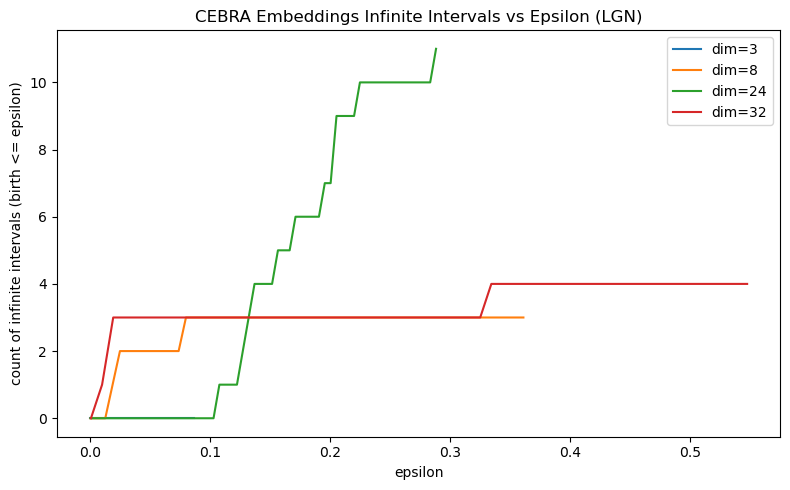


Sample of infinite-counts DataFrame:


,dim,epsilon,count,count_fraction,total_infinite
0,3,0.000029,0,0.000000,0
1,3,0.001493,0,0.000000,0
2,3,0.002957,0,0.000000,0
3,3,0.004421,0,0.000000,0
4,3,0.005885,0,0.000000,0
5,3,0.007349,0,0.000000,0
60,8,0.000622,0,0.000000,3
61,8,0.006733,0,0.000000,3
62,8,0.012844,0,0.000000,3
63,8,0.018954,1,0.333333,3


In [7]:
# Plot number of infinite intervals per dimension vs increasing epsilon (birth threshold)

def plot_infinite_intervals_vs_epsilon(dgms_by_cat, dims=(3,8,24,32), n_eps=50, figsize=(8,5), cmap='tab10'):
    """Plot counts of infinite intervals (death == inf) vs a birth-threshold epsilon for each dim.
    For each dimension:
      - collect all interval births and infinite-interval births across diagrams
      - build an epsilon grid across the observed birth range 
      - count infinite-interval births are <= epsilon (cumulative count)

    Args:
        dgms_by_cat: dict category -> dim -> list of (n,2) arrays
        dims: iterable of int dimensions to include
        n_eps: int number of epsilon points between min and max birth
        figsize: tuple figure size for the plot
        cmap: str matplotlib colormap name
    Returns:
        DataFrame with columns ['dim','epsilon','count','count_fraction','total_infinite']
    """
    
    dims = tuple(dims)
    dim_diagrams = {}

    for dim in dims:
        combined = []
        for cat, dim_map in dgms_by_cat.items():
            if dim in dim_map:
                combined.extend(dim_map[dim])
        combined = [np.asarray(d, dtype=float) for d in combined if d is not None]
        dim_diagrams[dim] = combined

    rows = []
    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.get_cmap(cmap)

    for idx, dim in enumerate(dims):
        diagrams = dim_diagrams.get(dim, [])
        if len(diagrams) == 0:
            print(f"Skipping dim {dim}: no diagrams found")
            continue

        # collect births and infinite births
        all_births = []
        inf_births = []
        for d in diagrams:
            if d.size == 0:
                continue
            births = d[:,0]
            deaths = d[:,1]
            all_births.extend(births.tolist())
            mask_inf = np.isinf(deaths)
            if np.any(mask_inf):
                inf_births.extend(births[mask_inf].tolist())

        if len(all_births) == 0:
            print(f"Skipping dim {dim}: no birth values")
            continue

        if len(inf_births) == 0:
            print(f"Dim {dim}: no infinite intervals found (plotting zeros)")

        min_birth = float(np.min(all_births))
        max_birth = float(np.max(all_births))
        if max_birth <= min_birth:
            print(f"Skipping dim {dim}: birth range zero")
            continue

        epsilons = np.linspace(min_birth, max_birth, n_eps)
        inf_births_arr = np.array(inf_births, dtype=float)
        total_inf = int(inf_births_arr.size)

        counts = []
        frac_counts = []
        for eps in epsilons:
            if total_inf == 0:
                c = 0
            else:
                c = int(np.sum(inf_births_arr <= eps))
            counts.append(c)
            frac_counts.append(float(c) / total_inf if total_inf > 0 else 0.0)
            rows.append({
                'dim': int(dim),
                'epsilon': float(eps),
                'count': int(c),
                'count_fraction': float(frac_counts[-1]),
                'total_infinite': total_inf
            })

        c = colors(idx)
        ax.plot(epsilons, counts, label=f"dim={dim}", color=c)

    ax.set_xlabel('epsilon')
    ax.set_ylabel('count of infinite intervals (birth <= epsilon)')
    ax.set_title('CEBRA Embeddings Infinite Intervals vs Epsilon (LGN)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    df_out = pd.DataFrame(rows, columns=['dim','epsilon','count','count_fraction','total_infinite'])
    return df_out

# usage!!
try:
    dims = (3,8,24,32)
    datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"
    dgms_by_cat, df_meta = load_dgms_from_pickle(file_path=datadir, area_filter='LGN', dims=dims, hom_deg=2, file_ext=None)
    print('Files loaded:', len(df_meta))
    df_inf = plot_infinite_intervals_vs_epsilon(dgms_by_cat, dims=dims, n_eps=60)
    print('\nSample of infinite-counts DataFrame:')
    display(df_inf.groupby('dim').head(6))
except Exception as e:
    print('Error plotting infinite intervals vs epsilon:', repr(e))

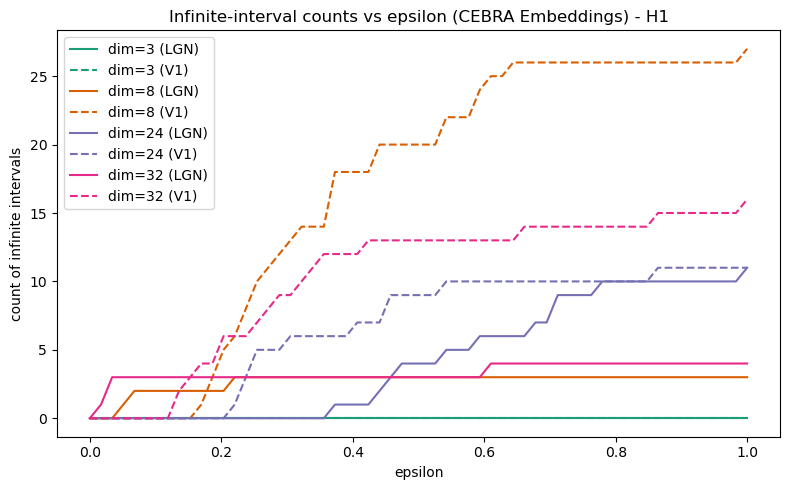


Sample rows:


,area,dim,epsilon_frac,epsilon_abs,count,total_infinite
0,LGN,3,0.000000,0.000029,0,0
1,LGN,3,0.016949,0.001493,0,0
2,LGN,3,0.033898,0.002957,0,0
3,LGN,3,0.050847,0.004421,0,0
4,LGN,3,0.067797,0.005885,0,0
5,LGN,3,0.084746,0.007349,0,0
60,V1,3,0.000000,0.000060,0,0
61,V1,3,0.016949,0.001304,0,0
62,V1,3,0.033898,0.002548,0,0
63,V1,3,0.050847,0.003793,0,0


In [8]:
# Plot infinite-interval counts per dimension separated by LGN vs V1

def plot_infinite_intervals_by_area(data_dir, dims=(3,8,24,32), areas=('LGN','V1'), n_eps=60, hom_deg=1, figsize=(8,5), cmap='Dark2'):
    """ Plot counts of infinite intervals vs birth-threshold epsilon for each dim and area.

    Args:
        data_dir: str path to directory containing pickle files
        dims: iterable of int dimensions to include
        areas: iterable of str areas to include (e.g., 'LGN', 'V1')
        n_eps: int number of epsilon points between min and max birth
        hom_deg: int homological degree to extract from diagrams
    Returns:
        DataFrame with columns ['area','dim','epsilon_frac','epsilon_abs','count','total_infinite']"""

    dims = tuple(dims)
    colors = plt.get_cmap('Dark2')
    linestyles = {areas[0]: '-', areas[1]: '--'} if len(areas) >= 2 else {areas[0]: '-'}

    combined_rows = []
    fig, ax = plt.subplots(figsize=figsize)

    for idx_dim, dim in enumerate(dims):
        color = colors(idx_dim)
        for area in areas:
            # load diagrams for this area only
            dgms_by_cat_area, df_meta_area = load_dgms_from_pickle(file_path=data_dir,
                                                                   area_filter=area,
                                                                   dims=(dim,),
                                                                   hom_deg=hom_deg,
                                                                   file_ext=None)
            # collect all diagrams for this dim across categories
            diagrams = []
            for cat, dim_map in dgms_by_cat_area.items():
                if dim in dim_map:
                    diagrams.extend(dim_map[dim])
            diagrams = [np.asarray(d, dtype=float) for d in diagrams if d is not None]

            if len(diagrams) == 0:
                print(f"Area {area}, dim {dim}: no diagrams found; skipping")
                continue

            # collect births and infinite births
            all_births = []
            inf_births = []
            for d in diagrams:
                if d.size == 0:
                    continue
                births = d[:,0]
                deaths = d[:,1]
                all_births.extend(births.tolist())
                mask_inf = np.isinf(deaths)
                if np.any(mask_inf):
                    inf_births.extend(births[mask_inf].tolist())

            if len(all_births) == 0:
                print(f"Area {area}, dim {dim}: no birth values; skipping")
                continue

            min_birth = float(np.min(all_births))
            max_birth = float(np.max(all_births))
            span = max_birth - min_birth
            if span <= 0:
                print(f"Area {area}, dim {dim}: zero birth span; skipping")
                continue

            inf_births_arr = np.array(inf_births, dtype=float)
            total_inf = int(inf_births_arr.size)

            eps_fracs = np.linspace(0.0, 1.0, n_eps)
            counts = []
            for frac in eps_fracs:
                threshold = min_birth + frac * span
                if total_inf == 0:
                    c = 0
                else:
                    c = int(np.sum(inf_births_arr <= threshold))
                counts.append(c)
                combined_rows.append({
                    'area': area,
                    'dim': int(dim),
                    'epsilon_frac': float(frac),
                    'epsilon_abs': float(threshold),
                    'count': int(c),
                    'total_infinite': total_inf
                })

            linestyle = linestyles.get(area, '-')
            ax.plot(eps_fracs, counts, label=f"dim={dim} ({area})", color=color, linestyle=linestyle)

    ax.set_xlabel('epsilon')
    ax.set_ylabel('count of infinite intervals')
    ax.set_title('Infinite-interval counts vs epsilon (CEBRA Embeddings) - H1')
    ax.legend()
    plt.tight_layout()
    plt.show()

    df_out = pd.DataFrame(combined_rows, columns=['area','dim','epsilon_frac','epsilon_abs','count','total_infinite'])
    return df_out

# usage!!
try:
    datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"
    dims = (3,8,24,32)
    df_inf_by_area = plot_infinite_intervals_by_area(datadir, dims=dims, areas=('LGN','V1'), n_eps=60, hom_deg=2)
    print('\nSample rows:')
    display(df_inf_by_area.groupby(['area','dim']).head(6))
except Exception as e:
    print('Error running plot_infinite_intervals_by_area:', repr(e))

In [9]:
# infinite interval metric - Infinite-Zero Index (IZI)

def infinite_zero_index(dgms_or_by_cat, weights, eps=1e-7, alpha=1):
    """ Compute the Infinite-Zero Index (IZI) for a collection of persistence diagrams.
    Args:
        dgms_or_by_cat: either
            - dict category -> dim -> list of (n,2) arrays (dgms_by_cat)
            - list/tuple of per-dimension diagrams: each entry is list of (n,2) arrays for that dim
        weights: dict mapping weight-keys to weights; weight-keys interpreted as either
            - dimension values (if dgms_or_by_cat is a dict)
            - indices into the list/tuple (if dgms_or_by_cat is a list/tuple)
        eps: float threshold for near-zero lifetime
        alpha: smoothing parameter for IZI calculation
    Returns:
        tuple (izi_weighted, per_dim) where
            izi_weighted: float overall weighted IZI
            per_dim: dict dim_value -> dict with keys:
                - weight: normalized weight for this dim
                - N_inf: count of infinite intervals in this dim
                - N_zero: count of near-zero intervals in this dim
                - IZI: IZI value for this dim
    """

    # normalize weights
    total_weight = float(sum(weights.values()))
    if total_weight == 0:
        raise ValueError('weights must sum to a positive value')
    weights_norm = {k: float(v)/total_weight for k, v in weights.items()}

    # Determine mapping from weight-keys -> actual dims present in data
    mapping = {}
    if isinstance(dgms_or_by_cat, dict):
        # collect available dims across categories
        available_dims = set()
        for dim_map in dgms_or_by_cat.values():
            if isinstance(dim_map, dict):
                for dd in dim_map.keys():
                    try:
                        available_dims.add(int(dd))
                    except Exception:
                        pass
        available_dims = sorted(available_dims)

        # if weight keys already match available_dims then use them directly
        if set(weights.keys()).issubset(set(available_dims)):
            for k in weights.keys():
                mapping[k] = int(k)
        else:
            # try to interpret weight keys as indices 0..k-1 mapping into sorted available_dims
            all_int_keys = all(isinstance(k, int) and k >= 0 for k in weights.keys())
            if all_int_keys and available_dims and max(weights.keys()) < len(available_dims):
                for k in weights.keys():
                    mapping[k] = available_dims[k]
            else:
                raise ValueError(f"Cannot map weight keys {list(weights.keys())} to available dims {available_dims}.\n" 
                                 "Use weight keys equal to dims (e.g. {3:1,8:1,32:1}) or supply a list-like dgms structure.")
    elif isinstance(dgms_or_by_cat, (list, tuple)):
        # weights keys should correspond to indices in the list
        for k in weights.keys():
            if not (isinstance(k, int) and 0 <= k < len(dgms_or_by_cat)):
                raise ValueError('When passing a list/tuple of per-dimension diagrams, weight keys must be integer indices into that list')
            mapping[k] = k
    else:
        raise TypeError('dgms_or_by_cat must be either a dict (dgms_by_cat) or a list/tuple of per-dimension diagrams')

    per_dim = {}
    izi_weighted = 0.0

    # helper: collect diagrams for a concrete dim value from dgms_by_cat or list
    def _collect_diagrams_for_dim_value(dim_value, source):
        diagrams = []
        if isinstance(source, dict):
            for cat, dim_map in source.items():
                if not isinstance(dim_map, dict):
                    continue
                if dim_value in dim_map:
                    items = dim_map[dim_value]
                    if items is None:
                        continue
                    if isinstance(items, (list, tuple)):
                        diagrams.extend(items)
                    else:
                        diagrams.append(items)
        elif isinstance(source, (list, tuple)):
            if dim_value < len(source) and source[dim_value] is not None:
                items = source[dim_value]
                if isinstance(items, (list, tuple)):
                    diagrams.extend(items)
                else:
                    diagrams.append(items)
        return diagrams

    for weight_key, w in weights_norm.items():
        dim_value = mapping[weight_key]
        diagrams = _collect_diagrams_for_dim_value(dim_value, dgms_or_by_cat)

        N_inf = 0
        N_zero = 0

        for dgm in diagrams:
            if dgm is None:
                continue
            arr = np.asarray(dgm, dtype=float)
            if arr.size == 0:
                continue
            # ensure shape is Nx2
            if arr.ndim == 1:
                if arr.size == 2:
                    arr = arr.reshape((1,2))
                else:
                    try:
                        arr = arr.reshape((-1,2))
                    except Exception:
                        continue

            births = arr[:,0]
            deaths = arr[:,1]
            is_inf = np.isinf(deaths)
            lifetimes = np.where(is_inf, np.inf, deaths - births)
            is_zero = (~is_inf) & (lifetimes <= eps)

            N_inf += int(np.sum(is_inf))
            N_zero += int(np.sum(is_zero))

        IZI_d = np.log((N_inf + alpha) / (N_zero + alpha))
        per_dim[dim_value] = dict(weight=w, N_inf=N_inf, N_zero=N_zero, IZI=IZI_d)
        izi_weighted += w * IZI_d

    return float(izi_weighted), per_dim


weights = {0:0.5, 1:1, 2:1}
try:
    if 'dgms_by_cat' in globals():
        izi_value, details = infinite_zero_index(dgms_by_cat, weights)
    else:
        izi_value, details = infinite_zero_index(globals().get('dgms', []), weights)

    print(f'Infinite Zero Index: {izi_value:.4f}')
    print(details)
except Exception as e:
    print('Error computing infinite_zero_index:', repr(e))

Infinite Zero Index: 1.2712
{3: {'weight': 0.2, 'N_inf': 0, 'N_zero': 0, 'IZI': 0.0}, 8: {'weight': 0.4, 'N_inf': 3, 'N_zero': 1, 'IZI': 0.6931471805599453}, 24: {'weight': 0.4, 'N_inf': 11, 'N_zero': 0, 'IZI': 2.4849066497880004}}


In [10]:
# summarize infinite and near-zero intervals per category/dimension

def summarize_inf_zero(dgms_by_cat, eps=1e-7, max_examples=3):
    """ Summarize infinite and near-zero intervals per category/dimension.
    Args:
        dgms_by_cat: dict category -> dim -> list of (n,2) arrays
        eps: float threshold for near-zero lifetime
        max_examples: int maximum number of example diagram shapes to print per dim/category
    Returns:
        DataFrame with columns ['category','dim','n_files','total_intervals','N_inf','N_zero'] """
    
    rows = []
    for cat, dim_map in dgms_by_cat.items():
        if not isinstance(dim_map, dict):
            continue
        for dim, diagrams in dim_map.items():
            total_intervals = 0
            N_inf = 0
            N_zero = 0
            n_files = 0
            for d in diagrams:
                if d is None:
                    continue
                arr = np.asarray(d, dtype=float)
                if arr.size == 0:
                    continue
                # normalize shape
                if arr.ndim == 1:
                    if arr.size == 2:
                        arr = arr.reshape((1,2))
                    else:
                        try:
                            arr = arr.reshape((-1,2))
                        except Exception:
                            continue
                births = arr[:,0]
                deaths = arr[:,1]
                is_inf = np.isinf(deaths)
                lifetimes = np.where(is_inf, np.inf, deaths - births)
                is_zero = (~is_inf) & (lifetimes <= eps)

                total_intervals += int(arr.shape[0])
                N_inf += int(np.sum(is_inf))
                N_zero += int(np.sum(is_zero))
                n_files += 1

            rows.append({
                'category': cat,
                'dim': int(dim),
                'n_files': int(n_files),
                'total_intervals': int(total_intervals),
                'N_inf': int(N_inf),
                'N_zero': int(N_zero)
            })
    df = pd.DataFrame(rows, columns=['category','dim','n_files','total_intervals','N_inf','N_zero'])
    if df.empty:
        print('No diagrams found in dgms_by_cat')
    else:
        display(df.sort_values(['dim','category']).reset_index(drop=True))

    # print a few example diagram shapes
    print('\nExample diagram shapes (up to {} examples per dim/category):'.format(max_examples))
    for cat, dim_map in dgms_by_cat.items():
        for dim, diagrams in dim_map.items():
            shown = 0
            for i, d in enumerate(diagrams):
                if shown >= max_examples:
                    break
                if d is None:
                    continue
                a = np.asarray(d)
                print(f'category={cat} dim={dim} sample={i} shape={a.shape}')
                shown += 1

    return df


try:
    if 'dgms_by_cat' not in globals():
        datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"
        print('Loading diagrams from', datadir)
        dgms_by_cat, df_meta = load_dgms_from_pickle(file_path=datadir, area_filter=None, dims=(3,8,32), hom_deg=2, file_ext=None)
    else:
        print('Using dgms_by_cat already in notebook namespace')

    if 'df_meta' in globals():
        print('\nSample metadata (first 12 rows):')
        display(df_meta.head(12))

    df_summary = summarize_inf_zero(dgms_by_cat, eps=1e-7, max_examples=3)

except Exception as e:
    print('Error running diagnostic:', repr(e))

Using dgms_by_cat already in notebook namespace

Sample metadata (first 12 rows):


,area,dim,category,mouse_id,file,hom_deg,n_intervals
0,LGN,24,cex,C153,CEBRA_24d_LGN_cex_C153.pkl,2,816
1,LGN,24,cex,C159,CEBRA_24d_LGN_cex_C159.pkl,2,898
2,LGN,24,cg,C161,CEBRA_24d_LGN_cg_C161.pkl,2,3588
3,LGN,24,dg,C161,CEBRA_24d_LGN_dg_C161.pkl,2,4847
4,LGN,24,lf,C160,CEBRA_24d_LGN_lf_C160.pkl,2,160
5,LGN,32,cex,C153,CEBRA_32d_LGN_cex_C153.pkl,2,2228
6,LGN,32,cex,C159,CEBRA_32d_LGN_cex_C159.pkl,2,1015
7,LGN,32,cg,C159,CEBRA_32d_LGN_cg_C159.pkl,2,3180
8,LGN,32,dg,C159,CEBRA_32d_LGN_dg_C159.pkl,2,1905
9,LGN,32,lf,C159,CEBRA_32d_LGN_lf_C159.pkl,2,143


,category,dim,n_files,total_intervals,N_inf,N_zero
0,cex,3,2,23,0,0
1,cg,3,1,15,0,0
2,dg,3,1,12,0,0
3,lf,3,2,19,0,0
4,cex,8,2,1059,0,1
5,cg,8,1,2575,2,0
6,dg,8,1,1713,1,0
7,lf,8,1,172,0,0
8,cex,24,2,1714,0,0
9,cg,24,1,3588,3,0



Example diagram shapes (up to 3 examples per dim/category):
category=cex dim=24 sample=0 shape=(816, 2)
category=cex dim=24 sample=1 shape=(898, 2)
category=cex dim=32 sample=0 shape=(2228, 2)
category=cex dim=32 sample=1 shape=(1015, 2)
category=cex dim=3 sample=0 shape=(8, 2)
category=cex dim=3 sample=1 shape=(15, 2)
category=cex dim=8 sample=0 shape=(887, 2)
category=cex dim=8 sample=1 shape=(172, 2)
category=cg dim=24 sample=0 shape=(3588, 2)
category=cg dim=32 sample=0 shape=(3180, 2)
category=cg dim=3 sample=0 shape=(15, 2)
category=cg dim=8 sample=0 shape=(2575, 2)
category=dg dim=24 sample=0 shape=(4847, 2)
category=dg dim=32 sample=0 shape=(1905, 2)
category=dg dim=3 sample=0 shape=(12, 2)
category=dg dim=8 sample=0 shape=(1713, 2)
category=lf dim=24 sample=0 shape=(160, 2)
category=lf dim=32 sample=0 shape=(143, 2)
category=lf dim=32 sample=1 shape=(286, 2)
category=lf dim=3 sample=0 shape=(12, 2)
category=lf dim=3 sample=1 shape=(7, 2)
category=lf dim=8 sample=0 shape=(172,

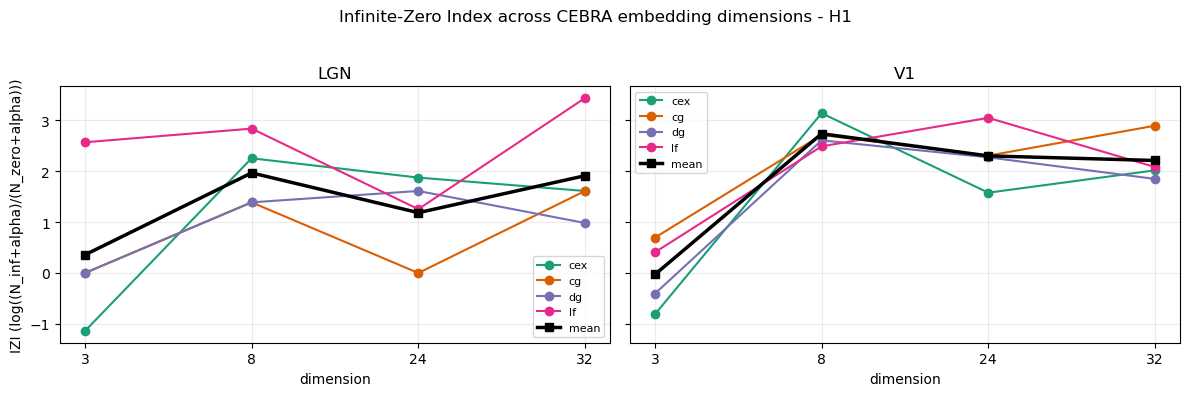


Per-dimension IZI table:


,area,category,dim,N_inf,N_zero,IZI
0,LGN,cex,3,7,24,-1.139434
1,LGN,cex,8,18,1,2.251292
2,LGN,cex,24,12,1,1.871802
3,LGN,cex,32,24,4,1.609438
4,LGN,cg,3,4,4,0.000000
5,LGN,cg,8,7,1,1.386294
6,LGN,cg,24,0,0,0.000000
7,LGN,cg,32,9,1,1.609438
8,LGN,dg,3,0,0,0.000000
9,LGN,dg,8,7,1,1.386294


In [11]:
def plot_izi_across_dims(data_dir, dims=(3,8,24,32), hom_deg=2, categories=('cg','cex','dg','lf'), eps=1e-7, alpha=1, figsize=(12,4), seed=0):
    """Compute per-dimension IZI for each category and plot across dimensions.

    Args:
        data_dir: directory containing pickled diagrams
        dims: tuple of dimensions to analyze
        hom_deg: homology degree
        categories: tuple of category labels to include
        eps: threshold for near-zero intervals
        alpha: smoothing parameter for IZI
        figsize: figure size for the plot
    Returns:
        DataFrame with per-dimension IZI values
    """
    rng = np.random.default_rng(seed)
    areas = ('LGN', 'V1')
    rows = []

    for area in areas:
        dgms_by_cat_area, df_meta_area = load_dgms_from_pickle(file_path=data_dir, area_filter=area, dims=dims, hom_deg=hom_deg, file_ext=None)

        for cat in categories:
            dim_map = dgms_by_cat_area.get(cat, {}) if isinstance(dgms_by_cat_area, dict) else {}
            for dim in dims:
                if dim in dim_map and len(dim_map[dim]) > 0:
                    try:
                        # compute IZI for this single-dimension by passing weight {dim:1}
                        izi_val, per_dim = infinite_zero_index({cat: dim_map}, {int(dim): 1}, eps=eps, alpha=alpha)
                        info = per_dim.get(int(dim), {})
                        rows.append({
                            'area': area,
                            'category': cat,
                            'dim': int(dim),
                            'N_inf': int(info.get('N_inf', 0)),
                            'N_zero': int(info.get('N_zero', 0)),
                            'IZI': float(info.get('IZI', np.nan))
                        })
                    except Exception as e:
                        rows.append({
                            'area': area,
                            'category': cat,
                            'dim': int(dim),
                            'N_inf': 0,
                            'N_zero': 0,
                            'IZI': np.nan,
                            'error': str(e)
                        })
                else:
                    rows.append({'area': area, 'category': cat, 'dim': int(dim), 'N_inf': 0, 'N_zero': 0, 'IZI': np.nan})

    df = pd.DataFrame(rows, columns=['area','category','dim','N_inf','N_zero','IZI'])

    # plot
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    colors = plt.get_cmap('Dark2')

    for ax_idx, area in enumerate(areas):
        ax = axes[ax_idx]
        df_a = df[df['area'] == area]
        if df_a.empty:
            ax.text(0.5, 0.5, f'No data for {area}', ha='center', va='center')
            ax.set_title(area)
            continue

        dims_sorted = list(dims)
        x = np.arange(len(dims_sorted))

        # Plot one line per category
        cats_present = sorted(df_a['category'].unique())
        for ci, cat in enumerate(cats_present):
            vals = []
            for dim in dims_sorted:
                row = df_a[(df_a['category'] == cat) & (df_a['dim'] == dim)]
                if row.empty:
                    vals.append(np.nan)
                else:
                    vals.append(float(row['IZI'].iloc[0]))
            vals = np.array(vals, dtype=float)
            ax.plot(x, vals, marker='o', label=cat, color=colors(ci))

        # mean across categories (skip NaNs)
        mean_vals = []
        for dim in dims_sorted:
            s = df_a[df_a['dim'] == dim]['IZI'].dropna().values
            mean_vals.append(np.nan if s.size == 0 else float(np.mean(s)))
        mean_vals = np.array(mean_vals, dtype=float)
        ax.plot(x, mean_vals, marker='s', color='k', linewidth=2.5, label='mean')

        ax.set_xticks(x)
        ax.set_xticklabels([str(d) for d in dims_sorted])
        ax.set_xlabel('dimension')
        if ax_idx == 0:
            ax.set_ylabel('IZI (log((N_inf+alpha)/(N_zero+alpha)))')
        ax.set_title(area)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.25)

    plt.suptitle('Infinite-Zero Index across CEBRA embedding dimensions - H1')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    return df


# Example usage
try:
    datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"
    df_izi_dims = plot_izi_across_dims(datadir, dims=(3,8,24,32), hom_deg=1, categories=('cg','cex','dg','lf'), eps=1e-7, alpha=1)
    print('\nPer-dimension IZI table:')
    display(df_izi_dims.sort_values(['area','category','dim']).reset_index(drop=True))
except Exception as e:
    print('Error running plot_izi_across_dims:', repr(e))

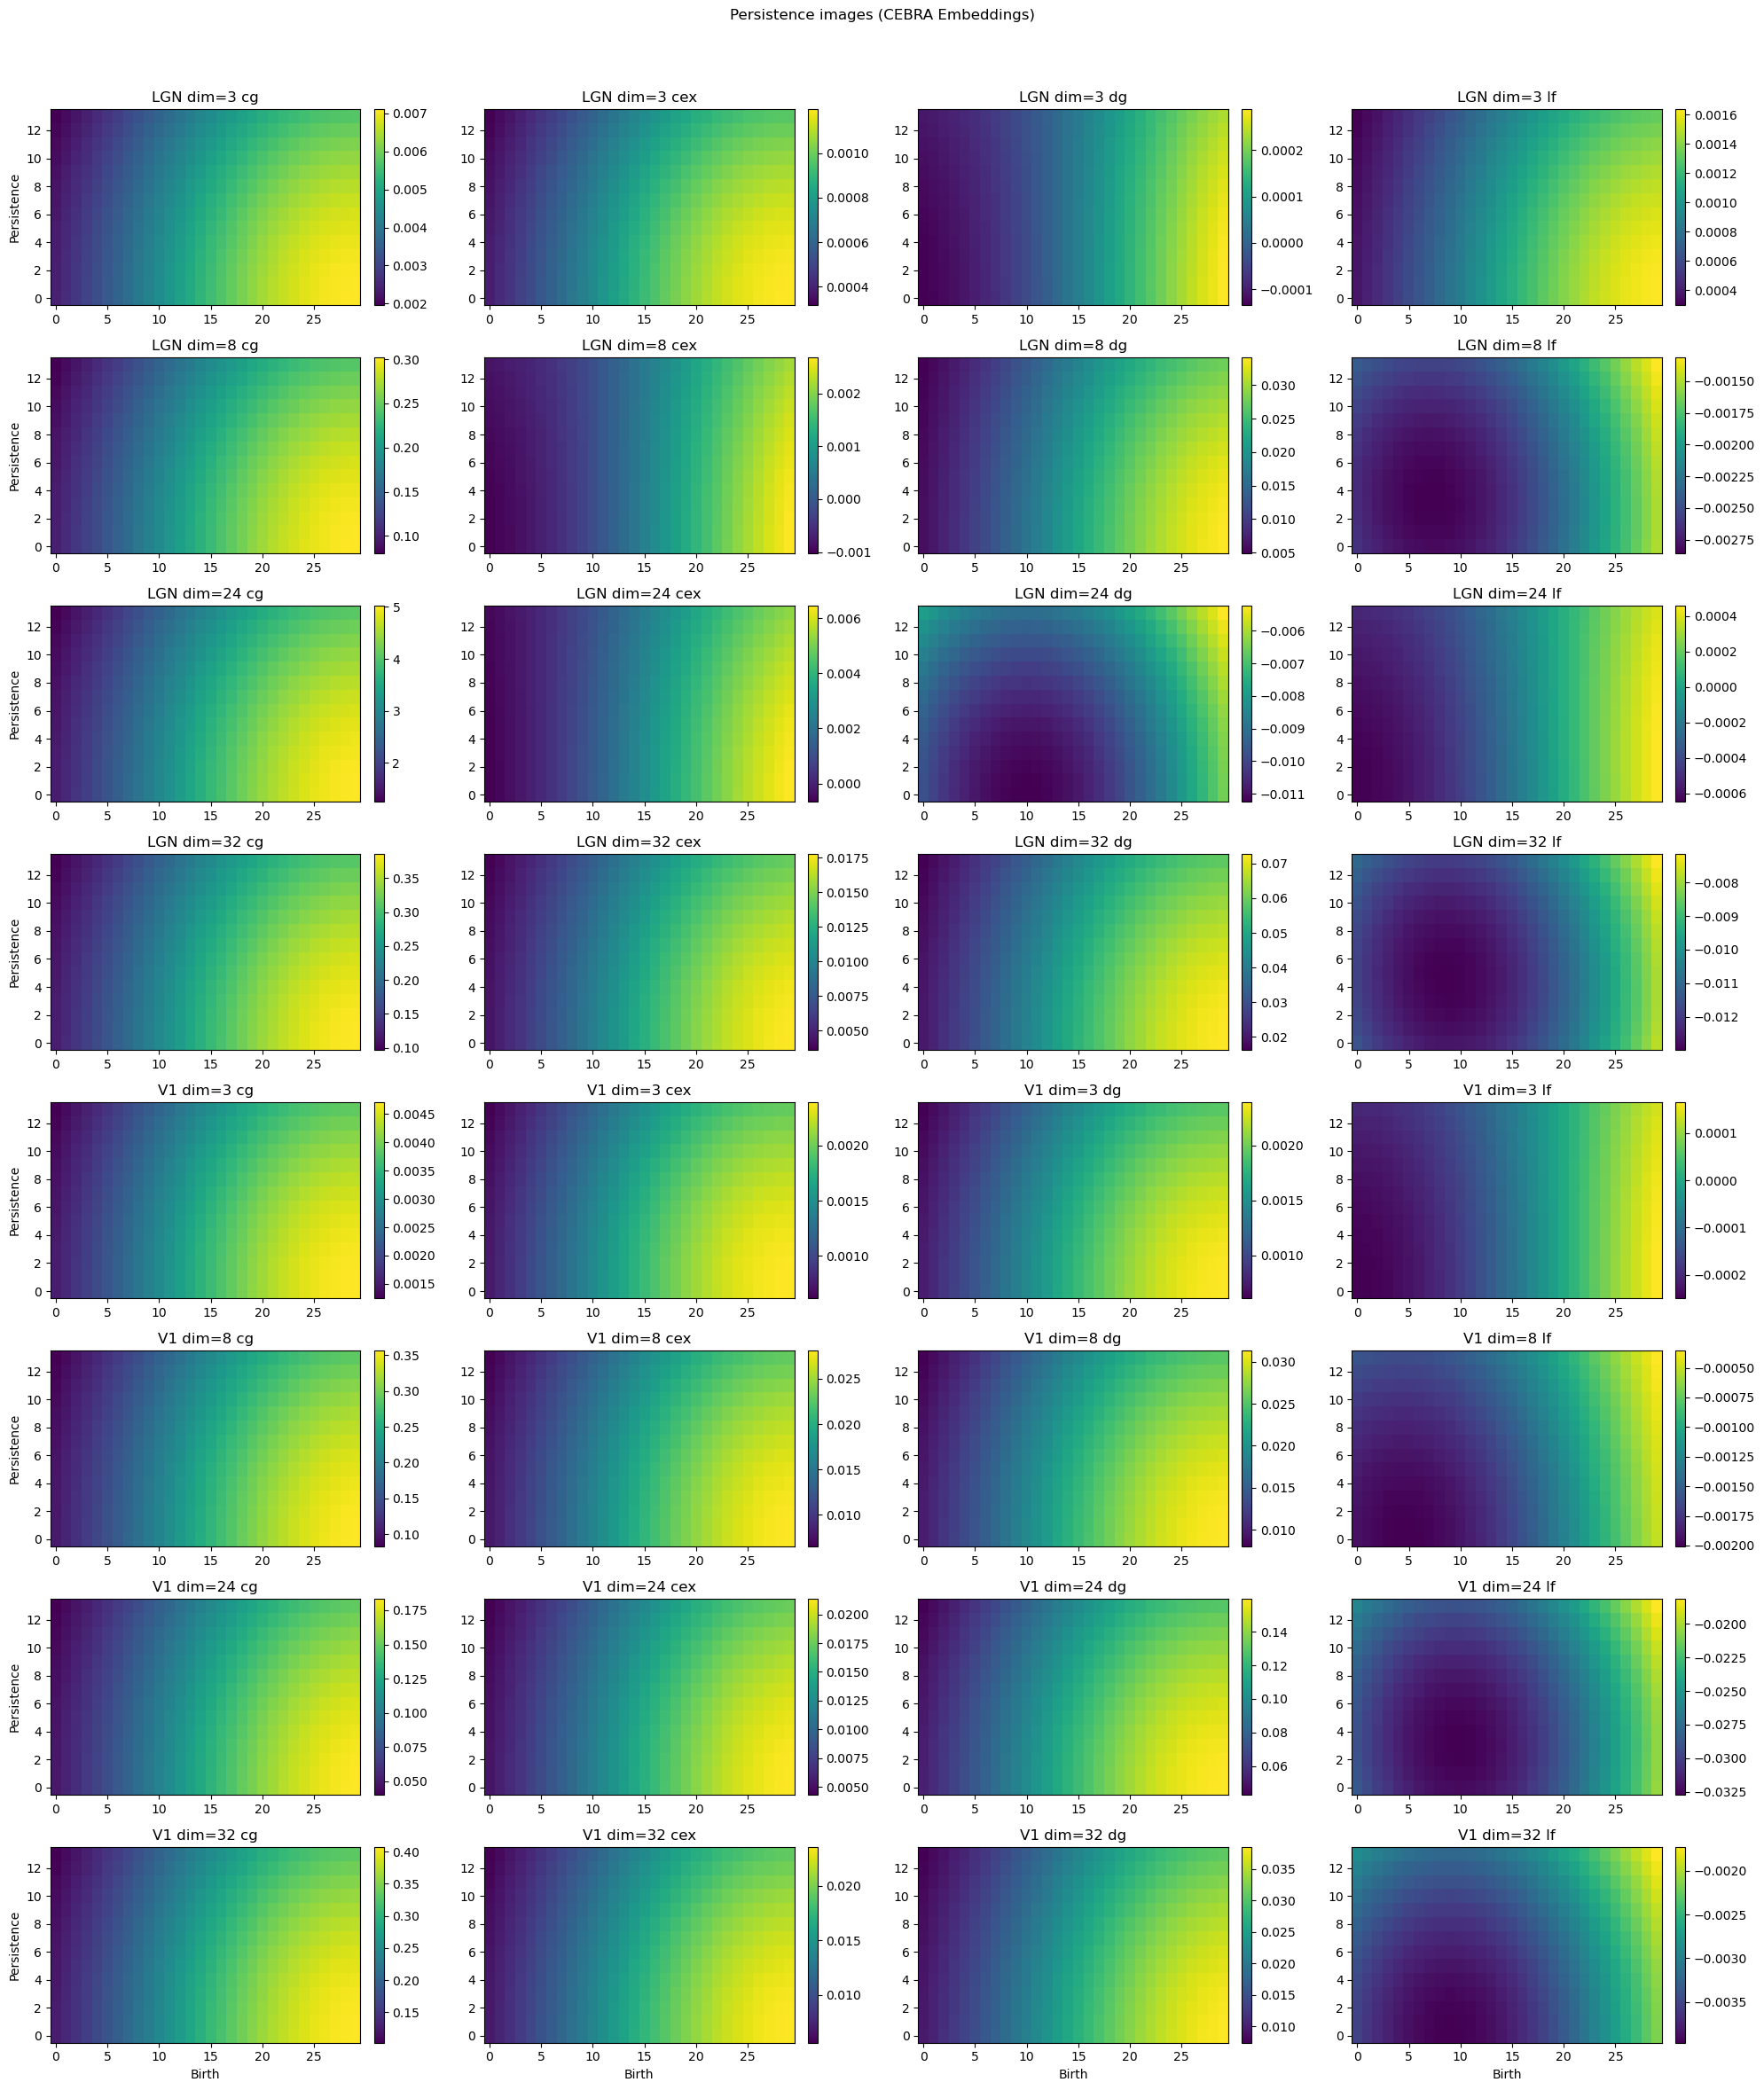

In [12]:
# persistence images from dgms (persistence diagrams)
# vector representation of persisdence diagrams
# higher pixel values = more robust topological features (aka longer lifetime)
# x and y axis are pixels - no unit related to persistence diagram
# pixel intensity scale is relative to gaussian kernel used

def persistence_images_one_per_category_persim(data_path, dims=(3,8,24,32), areas=('LGN','V1'), categories=('cg','cex','dg','lf'),
                                             hom_deg=2, resolution=(256,256), spread=None, cap_inf=None, display=True):
    """ Compute persistence images for diagrams in data_path, one diagram per category (uses first available dgms file).

    Args:
        - data_path: path to directory with pickled diagrams
        - dims: tuple of homological dimensions to consider
        - areas: tuple of brain areas to consider
        - categories: tuple of categories to consider
        - hom_deg: homology degree used in ripser computation   
        - resolution: (height,width) of output images
        - spread: standard deviation of Gaussian kernel (if None, defaults to 0.1 * max image dimension)
        - cap_inf: value to cap infinite deaths (if None, computed as 1.2 * max finite death across diagrams)
        - display: if True, display images in a grid
    Returns:
        - images: nested dict images[area][dim][category] = (image_array, error_info)"""

    pimg = PersistenceImager(pixel_size=0.05)  

    images = {area: {int(d): {} for d in dims} for area in areas}

    # dgms to fit
    fit_diagrams = []

    # First pass: collect one diagram per category (first available) and compute cap if needed
    for area in areas:
        dgms_by_cat, df_meta = load_dgms_from_pickle(file_path=data_path, area_filter=area, dims=dims, hom_deg=hom_deg, file_ext=None)
        for dim in dims:
            dim = int(dim)
            for cat in categories:
                if cat not in dgms_by_cat:
                    continue
                if dim not in dgms_by_cat[cat] or len(dgms_by_cat[cat][dim]) == 0:
                    continue
                d = dgms_by_cat[cat][dim][0]
                arr = np.asarray(d, dtype=float)
                if arr.size == 0:
                    continue
                # ensure shape Nx2
                if arr.ndim == 1:
                    if arr.size == 2:
                        arr = arr.reshape((1,2))
                    else:
                        try:
                            arr = arr.reshape((-1,2))
                        except Exception:
                            continue
                fit_diagrams.append((area, dim, cat, arr))

    # compute cap for infinite deaths
    if cap_inf is None:
        max_finite = -np.inf
        for (_area,_dim,_cat,arr) in fit_diagrams:
            deaths = arr[:,1]
            finite_deaths = deaths[np.isfinite(deaths)]
            if finite_deaths.size > 0:
                max_finite = max(max_finite, np.max(finite_deaths))
        if not np.isfinite(max_finite) or max_finite == -np.inf:
            cap_inf = None
        else:
            cap_inf = float(max_finite * 1.2)

    # convert diagram to birth-persistence pairs and cap infinities
    def _to_birth_persistence(arr, cap):
        births = arr[:,0]
        deaths = arr[:,1]
        if np.any(np.isinf(deaths)):
            if cap is not None:
                deaths = np.where(np.isinf(deaths), cap, deaths)
            else:
                # drop infinite deaths if no cap
                finite_mask = np.isfinite(deaths)
                births = births[finite_mask]
                deaths = deaths[finite_mask]
        lives = deaths - births
        mask = lives > 0
        if not np.any(mask):
            return np.zeros((0,2))
        bp = np.column_stack((births[mask], lives[mask]))
        return bp

    # Build list of diagrams (birth-persistence) for fit
    bp_list = []
    for (_area,_dim,_cat,arr) in fit_diagrams:
        bp = _to_birth_persistence(arr, cap_inf)
        if bp.size == 0:
            continue
        bp_list.append(bp)

    # Fit the imager to discovered diagrams to set axis ranges
    try:
        pimg.fit(bp_list)
    except Exception as e:
        print('Warning: PersistenceImager.fit failed, trying without fit. Error:', repr(e))
        try:
            pass
        except Exception:
            pass

    # Transform and store images
    for (area, dim, cat, arr) in fit_diagrams:
        bp = _to_birth_persistence(arr, cap_inf)
        if bp.size == 0:
            images[area][int(dim)][cat] = (None, 'no positive lifetimes after preprocessing')
            continue
        try:
            img = pimg.transform(bp)
        except Exception:
            # try wrapping in list
            try:
                img = pimg.transform([bp])[0]
            except Exception as e:
                images[area][int(dim)][cat] = (None, repr(e))
                continue
        images[area][int(dim)][cat] = (np.asarray(img, dtype=float), None)

    if display:
        # Plot grid: rows correspond to area x dim, columns categories
        ncols = len(categories)
        rows = []
        for area in areas:
            for dim in dims:
                dim = int(dim)
                cats_present = [c for c in categories if c in images[area][dim] and images[area][dim][c][0] is not None]
                if len(cats_present) == 0:
                    continue
                rows.append((area, dim))
        nrows = len(rows)
        if nrows == 0:
            print('No images available to display.')
            return images

        fig_h = max(3, nrows * 3)
        fig_w = max(3, ncols * 5)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h))
        if nrows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = axes[np.newaxis, :]
        elif ncols == 1:
            axes = axes[:, np.newaxis]

        for r_idx, (area, dim) in enumerate(rows):
            for c_idx, cat in enumerate(categories):
                ax = axes[r_idx, c_idx]
                cell = images[area][dim].get(cat, (None, None))
                img, info = cell
                if img is None:
                    ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                    ax.set_xticks([])
                    ax.set_yticks([])
                else:
                    im = ax.imshow(img, origin='lower', aspect='auto', cmap='viridis')
                    ax.set_title(f'{area} dim={dim} {cat}')
                    if r_idx == nrows - 1:
                        ax.set_xlabel('Birth')
                    if c_idx == 0:
                        ax.set_ylabel('Persistence')
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.suptitle('Persistence images (CEBRA Embeddings)')
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()

    return images

data_path = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H1"
imgs = persistence_images_one_per_category_persim(data_path, dims=(3,8,24,32), areas=('LGN','V1'), categories=('cg','cex','dg','lf'), hom_deg=1, resolution=(256,256))

Auto cap computed from max finite death: 0.5489 -> cap_inf=0.6587 (frac_inf=0.001)


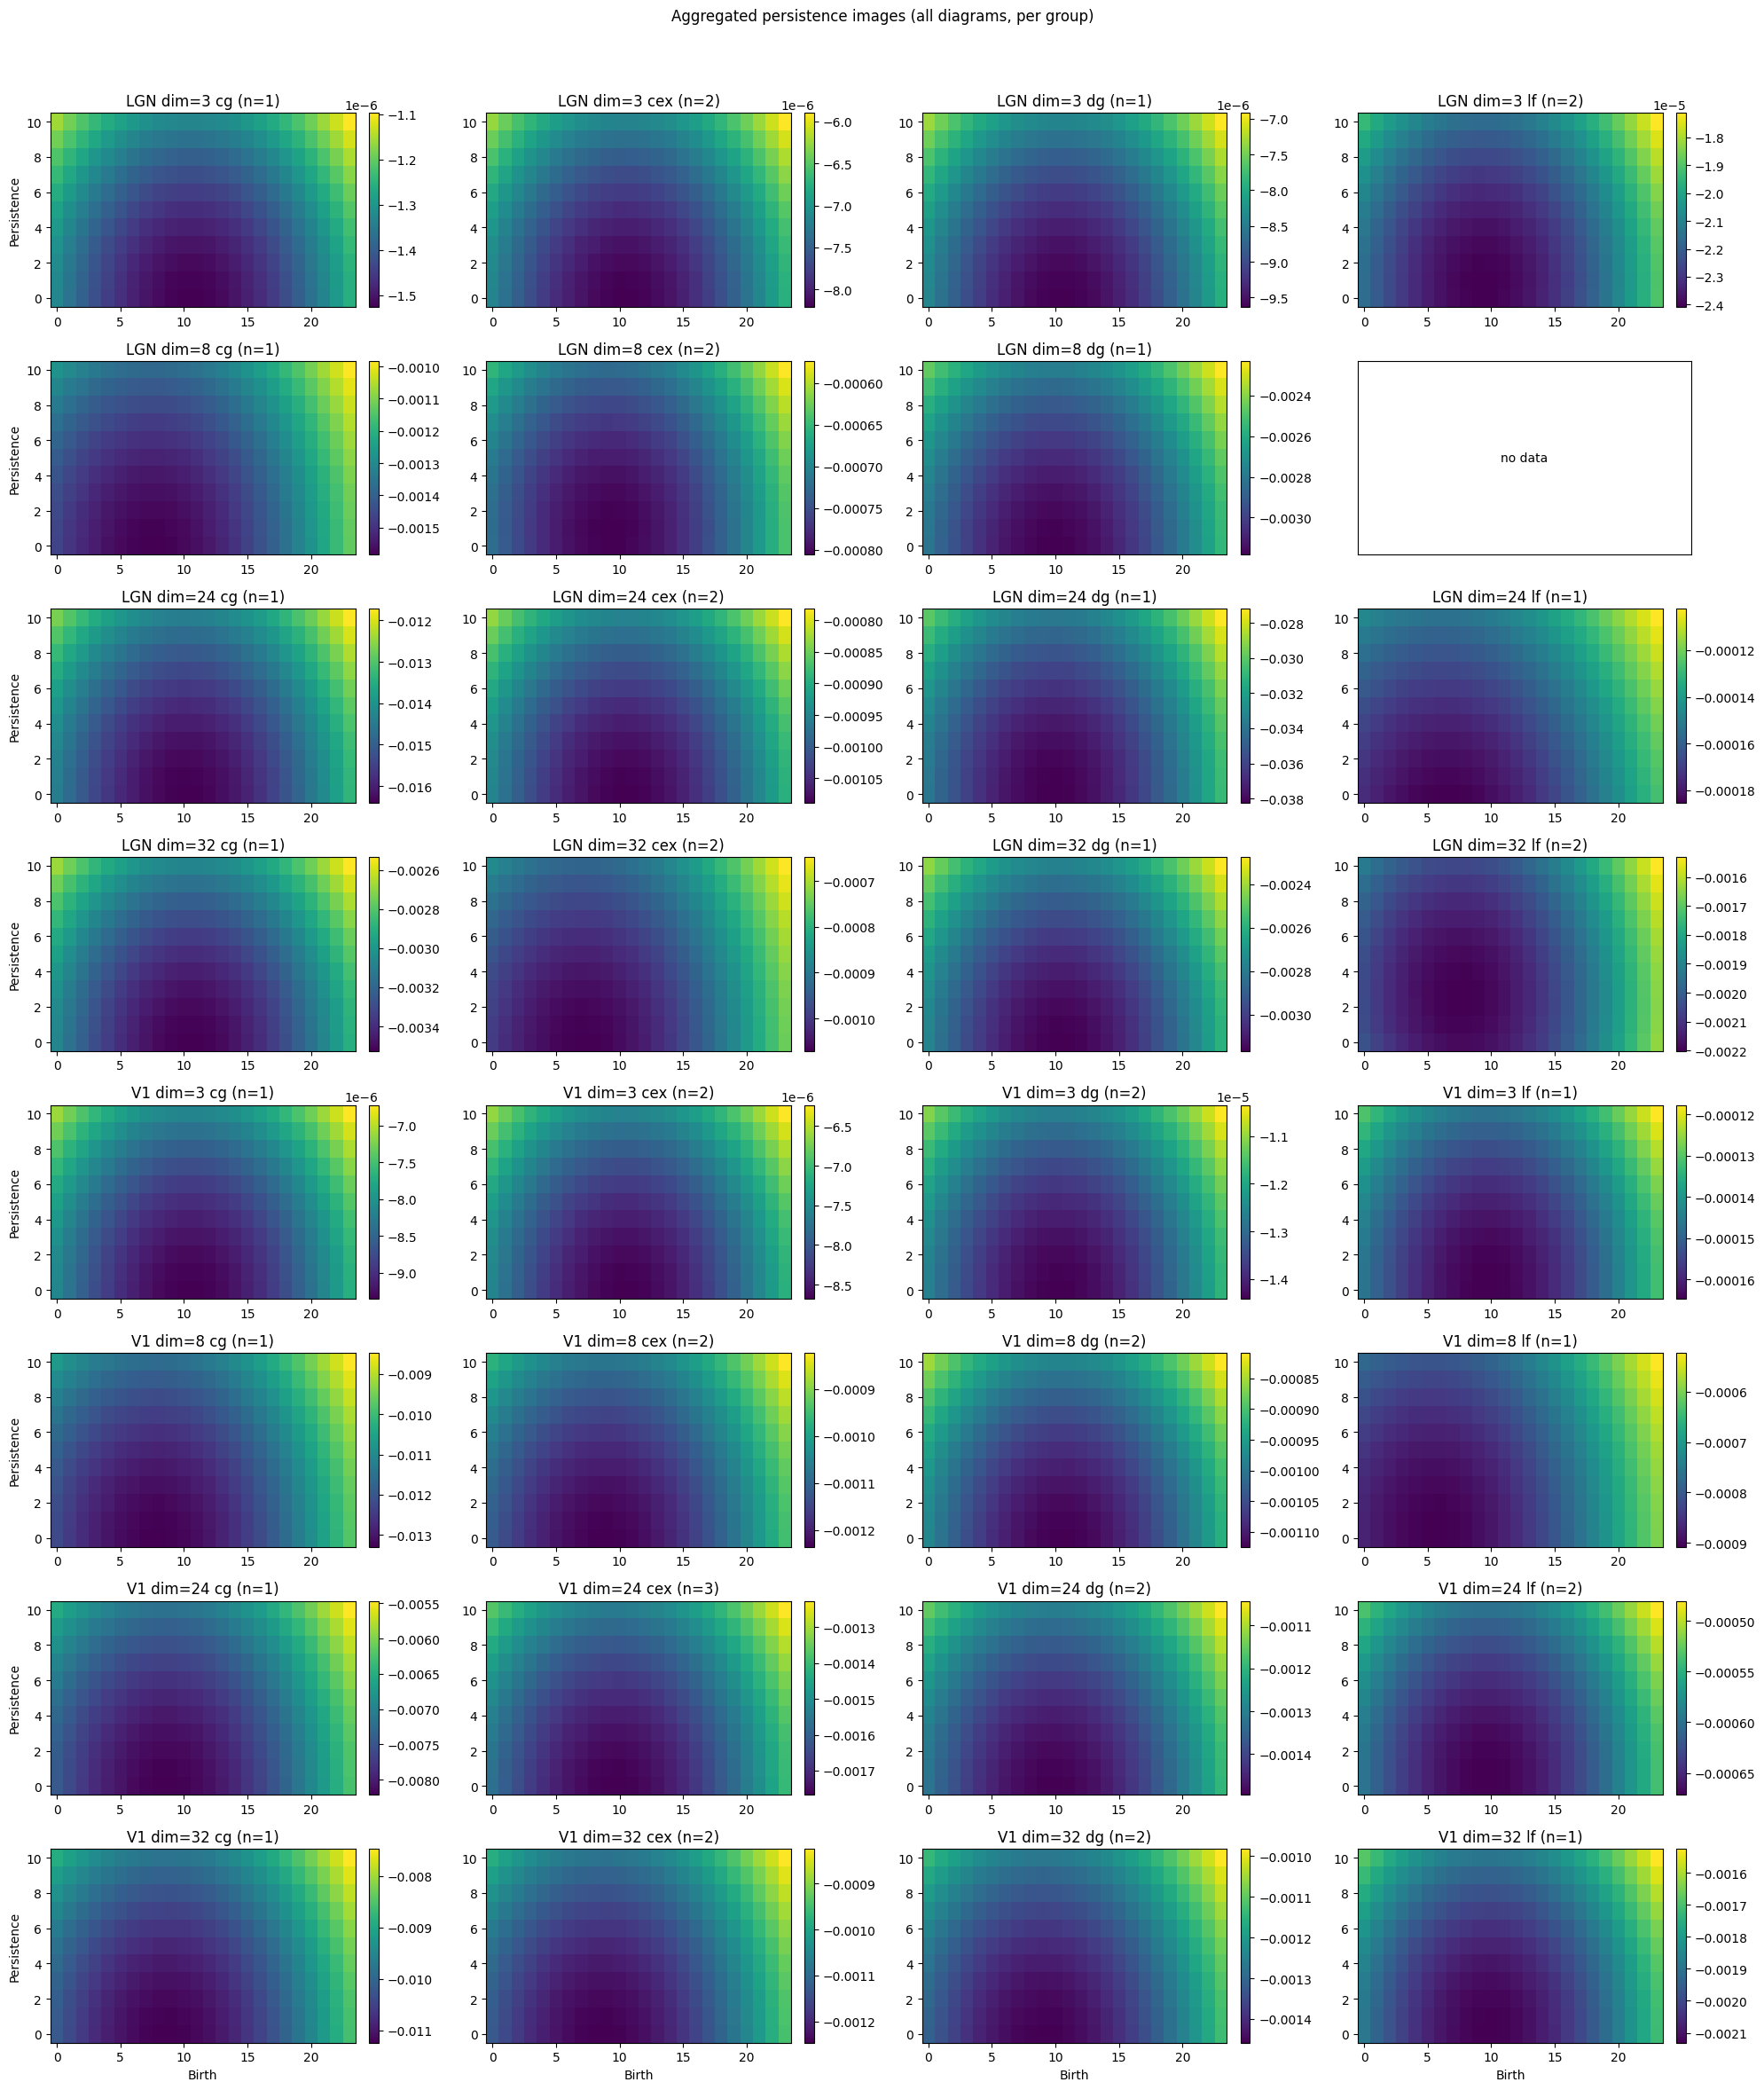


Group stats:


,area,dim,category,n_samples,aggregated
0,LGN,3,cex,2,True
1,LGN,3,cg,1,False
2,LGN,3,dg,1,False
3,LGN,3,lf,2,True
4,LGN,8,cex,2,True
5,LGN,8,cg,1,False
6,LGN,8,dg,1,False
7,LGN,8,lf,0,False
8,LGN,24,cex,2,True
9,LGN,24,cg,1,False


In [ ]:
# Persistence images (persim) but compute images for all diagrams and average per (area,dim,category) when >1 sample

def persistence_images_all_and_average_persim(data_dir, dims=(3,8,32), areas=('LGN','V1'), categories=('cg','cex','dg','lf'),
                                              hom_deg=1, resolution=(60,40), spread=None, cap_inf=None, auto_cap=True,
                                              min_samples_to_display=1, aggregator='mean', display=True, save_to_dir=None):
    
    """ Compute persistence images for all diagrams in specified groups,
        averaging when multiple diagrams exist per (area,dim,category).
        from persim import PersistenceImager
        Args:
            data_dir (str): directory containing pickled persistence diagrams
            dims (tuple): dimensions to process
            areas (tuple): area labels to process
            categories (tuple): category labels to process
            hom_deg (int): homology degree used in diagram computation
            resolution (tuple): (n_pixels_x, n_pixels_y) for persistence images
            spread (float or None): spread for Gaussian kernel in persistence imager
            cap_inf (float or None): cap value for infinite deaths; if None and auto_cap is True, compute automatically
            auto_cap (bool): whether to compute cap_inf automatically if cap_inf is None
            min_samples_to_display (int): minimum number of samples required to display averaged image
            aggregator (str): 'mean' or 'median' for aggregating multiple images
            display (bool): whether to display the resulting images
            save_to_dir (str or None): if provided, directory to save averaged images as .npy files
        Returns:
            images_agg (dict): nested dict images_agg[area][dim][category] = averaged image or None
            df_stats (pd.DataFrame): DataFrame with statistics per (area,dim,category)"""

    pimg = PersistenceImager(pixel_size=0.05)

    # load all diagrams for dims/areas/categories
    dgms_by_cat_all, df_meta_all = load_dgms_from_pickle(file_path=data_dir, area_filter=None, dims=dims, hom_deg=hom_deg, file_ext=None)

    # compute cap if requested
    if cap_inf is None and auto_cap:
        max_finite = -np.inf
        max_birth = -np.inf
        total_intervals = 0
        total_inf = 0
        for cat, dim_map in dgms_by_cat_all.items():
            if not isinstance(dim_map, dict):
                continue
            for dim, diagrams in dim_map.items():
                for d in diagrams:
                    if d is None:
                        continue
                    arr = np.asarray(d, dtype=float)
                    if arr.size == 0:
                        continue
                    if arr.ndim == 1:
                        if arr.size == 2:
                            arr = arr.reshape((1,2))
                        else:
                            try:
                                arr = arr.reshape((-1,2))
                            except Exception:
                                continue
                    births = arr[:,0]
                    deaths = arr[:,1]
                    total_intervals += int(arr.shape[0])
                    finite_mask = np.isfinite(deaths)
                    total_inf += int(np.sum(~finite_mask))
                    finite_deaths = deaths[finite_mask]
                    if finite_deaths.size > 0:
                        max_finite = max(max_finite, np.max(finite_deaths))
                    if births.size > 0:
                        max_birth = max(max_birth, np.max(births))
        frac_inf = float(total_inf)/float(total_intervals) if total_intervals>0 else 0.0
        if np.isfinite(max_finite) and max_finite != -np.inf:
            cap_inf = float(max_finite * 1.2)
            print(f'Auto cap computed from max finite death: {max_finite:.4g} -> cap_inf={cap_inf:.4g} (frac_inf={frac_inf:.3f})')
        elif np.isfinite(max_birth) and max_birth != -np.inf:
            cap_inf = float(max_birth + 1.0)
            print(f'No finite deaths found; using cap_inf = max_birth + 1: {cap_inf:.4g} (frac_inf={frac_inf:.3f})')
        else:
            cap_inf = None
            print('Unable to compute auto cap (no birth/death data found). cap_inf left as None')
    elif cap_inf is not None:
        print(f'Using user-supplied cap_inf = {cap_inf}')

    # helper to convert to birth-persistence pairs
    def _to_birth_persistence(arr, cap):
        arr = np.asarray(arr, dtype=float)
        if arr.size == 0:
            return np.zeros((0,2))
        if arr.ndim == 1:
            if arr.size == 2:
                arr = arr.reshape((1,2))
            else:
                try:
                    arr = arr.reshape((-1,2))
                except Exception:
                    return np.zeros((0,2))
        births = arr[:,0]
        deaths = arr[:,1]
        if np.any(np.isinf(deaths)):
            if cap is not None:
                deaths = np.where(np.isinf(deaths), cap, deaths)
            else:
                finite_mask = np.isfinite(deaths)
                births = births[finite_mask]
                deaths = deaths[finite_mask]
        lives = deaths - births
        mask = lives > 0
        if not np.any(mask):
            return np.zeros((0,2))
        bp = np.column_stack((births[mask], lives[mask]))
        return bp

    # Build bp_list for fitting the imager
    bp_list = []
    for cat, dim_map in dgms_by_cat_all.items():
        if not isinstance(dim_map, dict):
            continue
        for dim, diagrams in dim_map.items():
            if int(dim) not in [int(d) for d in dims]:
                continue
            for d in diagrams:
                if d is None:
                    continue
                bp = _to_birth_persistence(d, cap_inf)
                if bp.size == 0:
                    continue
                bp_list.append(bp)

    if len(bp_list) == 0:
        print('No valid birth-persistence points found to fit PersistenceImager.')
        return {}, pd.DataFrame()

    try:
        pimg.fit(bp_list)
    except Exception as e:
        print('Warning: PersistenceImager.fit failed:', repr(e))

    images_agg = {area: {int(d): {} for d in dims} for area in areas}
    stats = []

    # for each group, transform all diagrams and aggregate if multiple
    # this was mostly chat so take it up with AI if you're confused!! hehehe
    for area in areas:
        dgms_by_cat_area, df_meta_area = load_dgms_from_pickle(file_path=data_dir, area_filter=area, dims=dims, hom_deg=hom_deg, file_ext=None)
        for dim in dims:
            dim = int(dim)
            for cat in categories:
                # collect diagrams for this group
                diagrams = []
                if cat in dgms_by_cat_area and dim in dgms_by_cat_area[cat]:
                    diagrams = [d for d in dgms_by_cat_area[cat][dim] if d is not None]
                n = len(diagrams)
                stats.append({'area': area, 'dim': dim, 'category': cat, 'n_samples': n, 'aggregated': False})
                if n == 0:
                    images_agg[area][dim][cat] = None
                    continue
                imgs = []
                for d in diagrams:
                    bp = _to_birth_persistence(d, cap_inf)
                    if bp.size == 0:
                        continue
                    try:
                        img = pimg.transform(bp)
                    except Exception:
                        try:
                            img = pimg.transform([bp])[0]
                        except Exception as e:
                            print(f'Warning: transform failed for area={area} dim={dim} cat={cat}:', repr(e))
                            img = None
                    if img is None:
                        continue
                    imgs.append(np.asarray(img, dtype=float))
                if len(imgs) == 0:
                    images_agg[area][dim][cat] = None
                    continue
                # aggregate: if more than one image, average; if one image just take it
                if len(imgs) == 1:
                    agg = imgs[0]
                else:
                    stack = np.stack(imgs, axis=0)
                    if aggregator == 'median':
                        agg = np.median(stack, axis=0)
                    else:
                        agg = np.mean(stack, axis=0)
                    stats[-1]['aggregated'] = True
                images_agg[area][dim][cat] = agg
                # optional save
                if save_to_dir is not None and agg is not None:
                    os.makedirs(save_to_dir, exist_ok=True)
                    fname = f"pimg_agg_{area}_dim{dim}_{cat}.npy"
                    np.save(os.path.join(save_to_dir, fname), agg)

    df_stats = pd.DataFrame(stats, columns=['area','dim','category','n_samples','aggregated'])

    if display:
        # Display grid of aggregated images (rows area x dim, cols categories)
        ncols = len(categories)
        rows_list = [(area, dim) for area in areas for dim in dims if any(images_agg[area][dim].get(c) is not None for c in categories)]
        nrows = len(rows_list)
        if nrows == 0:
            print('No aggregated images to display.')
            return images_agg, df_stats
        fig_h = max(3, nrows * 3)
        fig_w = max(3, ncols * 5)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h))
        if nrows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif nrows == 1:
            axes = axes[np.newaxis, :]
        elif ncols == 1:
            axes = axes[:, np.newaxis]
        for r_idx, (area, dim) in enumerate(rows_list):
            for c_idx, cat in enumerate(categories):
                ax = axes[r_idx, c_idx]
                img = images_agg[area][dim].get(cat)
                if img is None:
                    ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                    ax.set_xticks([])
                    ax.set_yticks([])
                else:
                    im = ax.imshow(img, origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')
                    ax.set_title(f'{area} dim={dim} {cat} (n={int(df_stats[(df_stats.area==area)&(df_stats.dim==dim)&(df_stats.category==cat)]["n_samples"].iloc[0])})')
                    if r_idx == nrows - 1:
                        ax.set_xlabel('Birth')
                    if c_idx == 0:
                        ax.set_ylabel('Persistence')
                    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.suptitle('Aggregated persistence images (all diagrams, per group)')
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()

    return images_agg, df_stats


try:
    datadir = r"C:\Users\denmanlab\Desktop\Emily_rotation\Ripser\CEBRA_H2"
    images_agg, df_stats = persistence_images_all_and_average_persim(datadir, dims=(3,8,24,32), areas=('LGN','V1'), categories=('cg','cex','dg','lf'), hom_deg=2, resolution=(120,80), aggregator='mean', save_to_dir=None)
    print('\nGroup stats:')
    display(df_stats.sort_values(['area','dim','category']).reset_index(drop=True))
except Exception as e:
    print('Error running persistence_images_all_and_average_persim:', repr(e))